# Importing dependencies

In [ ]:
conda install lightgbm


Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.12.0
  latest version: 23.3.1

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier


In [ ]:
data = pd.read_csv('/Users/imac/Desktop/train.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40428967 entries, 0 to 40428966
Data columns (total 24 columns):
 #   Column            Dtype  
---  ------            -----  
 0   id                float64
 1   click             int64  
 2   hour              int64  
 3   C1                int64  
 4   banner_pos        int64  
 5   site_id           object 
 6   site_domain       object 
 7   site_category     object 
 8   app_id            object 
 9   app_domain        object 
 10  app_category      object 
 11  device_id         object 
 12  device_ip         object 
 13  device_model      object 
 14  device_type       int64  
 15  device_conn_type  int64  
 16  C14               int64  
 17  C15               int64  
 18  C16               int64  
 19  C17               int64  
 20  C18               int64  
 21  C19               int64  
 22  C20               int64  
 23  C21               int64  
dtypes: float64(1), int64(14), object(9)
memory usage: 7.2+ GB


Dataset description:   
id: ad identifier   
click: 0/1 for non-click/click    
hour: format is YYMMDDHH, so 14091123 means 23:00 on Sept. 11, 2014 UTC.    
C1 — anonymized categorical variable   
banner_pos    
site_id    
site_domain   
site_category   
app_id   
app_domain   
app_category   
device_id   
device_ip   
device_model   
device_type   
device_conn_type   
C14-C21 — anonymized categorical variables   

In [ ]:
#checking null values
data.isnull().sum()

id                  0
click               0
hour                0
C1                  0
banner_pos          0
site_id             0
site_domain         0
site_category       0
app_id              0
app_domain          0
app_category        0
device_id           0
device_ip           0
device_model        0
device_type         0
device_conn_type    0
C14                 0
C15                 0
C16                 0
C17                 0
C18                 0
C19                 0
C20                 0
C21                 0
dtype: int64

# Exploratory Data Analysis

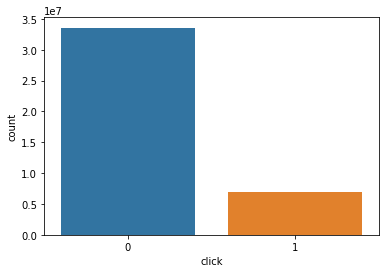

In [ ]:
#targets distribution
sns.countplot(x='click',data=data)
plt.show()

here, '0' means not clickable and
'1' means click
there are more number of not clicks than the clicks

In [ ]:
# adding prefix 20 to the year 
data['hour'] ='20' + data['hour'].astype(str)

In [ ]:
#converting string to dattetime format
data['hour']=pd.to_datetime(data['hour'],format='%Y%m%d%H')

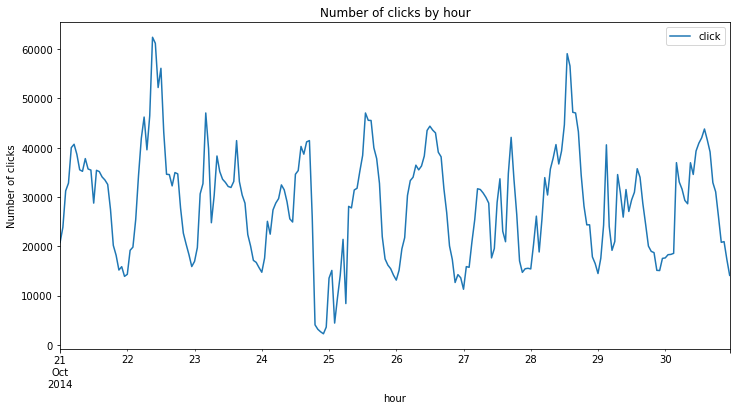

In [ ]:
data.groupby('hour').agg({'click':'sum'}).plot(figsize=(12,6))
plt.ylabel('Number of clicks')
plt.title('Number of clicks by hour');

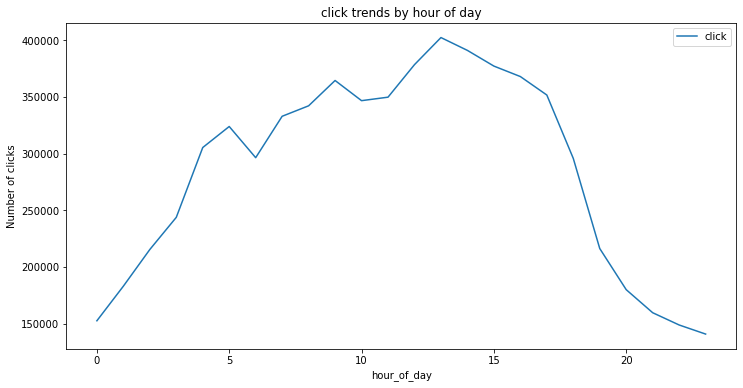

In [ ]:
data['hour_of_day'] = data.hour.apply(lambda x: x.hour)
data.groupby('hour_of_day').agg({'click':'sum'}).plot(figsize=(12,6))
plt.ylabel('Number of clicks')
plt.title('click trends by hour of day')
plt.show()

Text(0.5, 1.0, 'Hourly impressions vs. clicks')

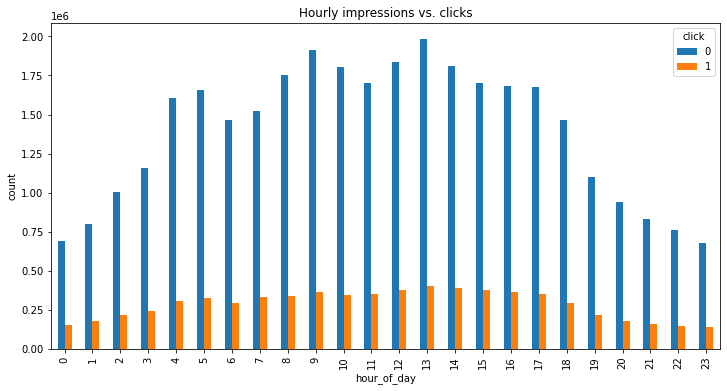

In [ ]:
data.groupby(['hour_of_day', 'click']).size().unstack().plot(kind='bar', title="Hour of Day", figsize=(12,6))
plt.ylabel('count')
plt.title('Hourly impressions vs. clicks')
plt.show()

Text(0.5, 1.0, 'Hourly CTR')

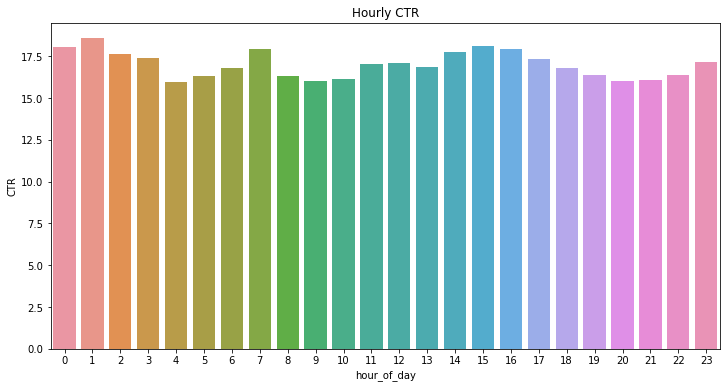

In [ ]:
df_click = data[data['click'] == 1]
df_hour = data[['hour_of_day','click']].groupby(['hour_of_day']).count().reset_index()
df_hour = df_hour.rename(columns={'click': 'impressions'})
df_hour['clicks'] = df_click[['hour_of_day','click']].groupby(['hour_of_day']).count().reset_index()['click']
df_hour['CTR'] = df_hour['clicks']/df_hour['impressions']*100
plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='hour_of_day', data=df_hour)
plt.title('Hourly CTR')
plt.show()

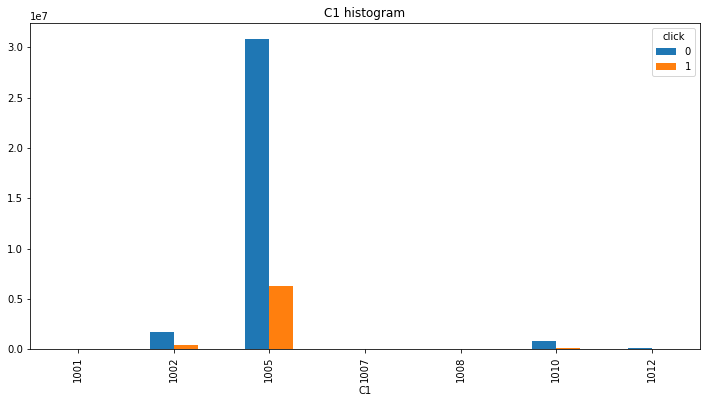

In [ ]:
data.groupby(['C1', 'click']).size().unstack().plot(kind='bar', figsize=(12,6), title='C1 histogram');

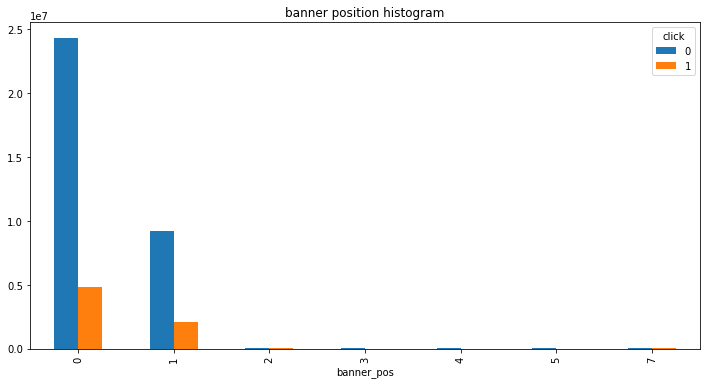

In [ ]:
data.groupby(['banner_pos', 'click']).size().unstack().plot(kind='bar', figsize=(12,6), title='banner position histogram');

In [ ]:
def convert_obj_to_int(self):
    
    object_list_columns = self.columns
    object_list_dtypes = self.dtypes
    new_col_suffix = '_int'
    for index in range(0,len(object_list_columns)):
        if object_list_dtypes[index] == object :
            self[object_list_columns[index]+new_col_suffix] = self[object_list_columns[index]].map( lambda  x: hash(x))
            self.drop([object_list_columns[index]],inplace=True,axis=1)
    return self
data = convert_obj_to_int(data)

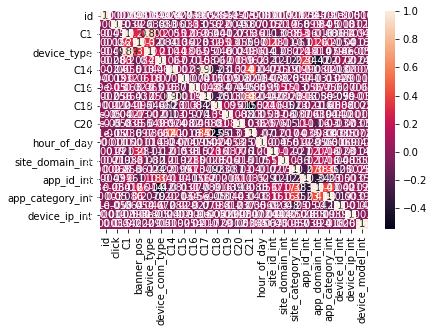

<Figure size 720x1080 with 0 Axes>

In [ ]:
sns.heatmap(data.corr(),annot=True)
plt.figure(figsize=(30,30))
plt.show()

In [ ]:
#subset of data
sub_data = data[:10000]
sub_data.to_csv('/Users/imac/Desktop/ctr_suset.csv')

In [ ]:
X = sub_data.drop(['id','click'],axis=1)
y = sub_data['click']

In [ ]:
#encoding the columns
X=X.apply(LabelEncoder().fit_transform)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# LGBM classifier|

In [ ]:

clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

LGBMClassifier()

In [ ]:
# predict the results
y_pred=clf.predict(X_test)

In [ ]:
# view accuracy
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))


LightGBM Model accuracy score: 0.8190


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

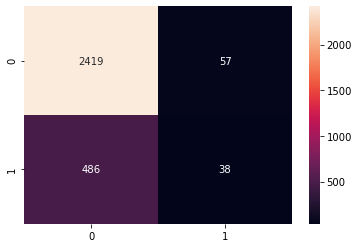

In [ ]:
sns.heatmap(cm,annot=True,fmt='g')
plt.show()

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.98      0.90      2476
           1       0.40      0.07      0.12       524

    accuracy                           0.82      3000
   macro avg       0.62      0.52      0.51      3000
weighted avg       0.76      0.82      0.76      3000



# Gradient Boosting classifier

In [ ]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

GradientBoostingClassifier()

In [ ]:
# predict the results
y_pred=gb.predict(X_test)

In [ ]:
# view accuracy
accuracy2=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

LightGBM Model accuracy score: 0.8240


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

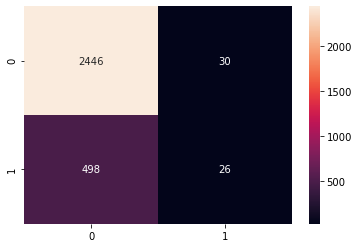

In [ ]:
sns.heatmap(cm,annot=True,fmt='g')
plt.show()

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.99      0.90      2476
           1       0.46      0.05      0.09       524

    accuracy                           0.82      3000
   macro avg       0.65      0.52      0.50      3000
weighted avg       0.77      0.82      0.76      3000

